In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd

import DarkNews as dn
from DarkNews import const

from DarkNews.GenLauncher import GenLauncher

In [4]:

gen_object = GenLauncher(m4 = 0.100, mzprime = 0.03, neval = 10000, nitn=40)
gen_object.run(log="INFO")


Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes
---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------
nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e- + C12
---------------------------------------------------------

Helicity conserving upscattering.
N4 decays via on-shell Z'.
Predicted (7.72e+08 +/- 9.39e+06) events.

----------------

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.5e+08 +/- 1.8e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.51e+08 +/- 1.81e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.83e+07 +/- 5.82e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (5.05e+07 +/- 6.03e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.72e+08 +/- 9.39e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------



P_projectile                       P_target                          \
                0    1    2         3          0    1    2             3   
0        0.278311  0.0  0.0  0.278311  11.174864 -0.0 -0.0 -3.330669e-15   
1        0.327314  0.0  0.0  0.327314  11.174864 -0.0 -0.0 -3.447242e-14   
2        0.203720  0.0  0.0  0.203720  11.174864 -0.0 -0.0  1.051936e-14   
3        0.223347  0.0  0.0  0.223347  11.174864 -0.0 -0.0 -1.165734e-14   
4        0.158117  0.0  0.0  0.158117  11.174864 -0.0 -0.0  4.596323e-14   
...           ...  ...  ...       ...        ...  ...  ...           ...   
9306     1.540746  0.0  0.0  1.540746  11.174864 -0.0 -0.0 -8.437695e-15   
9307     1.838624  0.0  0.0  1.838624  11.174864 -0.0 -0.0  6.439294e-15   
9308     1.618062  0.0  0.0  1.618062  11.174864 -0.0 -0.0  9.547918e-15   
9309     1.729406  0.0  0.0  1.729406  11.174864 -0.0 -0.0 -8.437695e-15   
9310     2.987122  0.0  0.0  2.987122  11.174864 -0.0 -0.0  2.664535e-15   

       P_recoil            ... w_flux_avg_xsec target target_pdgid  \
              0         1  ...                                       
0     11.174882  0.004704  ...    49229.964154    C12   1000060120   
1     11.174878  0.007866  ...    40479.919065    C12   1000060120   
2     11.174903 -0.006142  ...    47725.581112    C12   1000060120   
3     11.174890 -0.002448  ...    53196.168944    C12   1000060120   
4     11.174924 -0.006662  ...    59104.705972    C12   1000060120   
...         ...       ...  ...             ...    ...          ...   
9306  11.175262  0.089793  ...    26943.333962    C12   1000060120   
9307  11.175042 -0.023973  ...    30106.130162    C12   1000060120   
9308  11.177398  0.151414  ...     4053.277106    C12   1000060120   
9309  11.175283 -0.094789  ...    26744.859307    C12   1000060120   
9310  11.175129  0.004188  ...    34808.629943    C12   1000060120   

     scattering_regime    helicity  \
                                     
0             coherent  conserving   
1             coherent  conserving   
2             coherent  conserving   
3             coherent  conserving   
4             coherent  conserving   
...                ...         ...   
9306          coherent  conserving   
9307          coherent  conserving   
9308          coherent  conserving   
9309          coherent  conserving   
9310          coherent  conserving   

                                     underlying_process pos_decay              \
                                                                0           1   
0     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -141.867442   
1     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -381.022473   
2     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -274.736895   
3     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  455.251376   
4     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  -70.189261   
...                                                 ...       ...         ...   
9306  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -142.198905   
9307  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  268.893431   
9308  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -229.054503   
9309  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -129.873675   
9310  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -132.513989   

                              
               2           3  
0      -0.051698 -382.027656  
1    -370.579931  -99.268464  
2    -231.136448   28.502354  
3     -46.227442   45.876565  
4    -328.011717  151.161975  
...          ...         ...  
9306  308.966663   13.796481  
9307  -35.129149  -37.039370  
9308 -422.664632  -13.974871  
9309  -60.166620 -545.440527  
9310  259.961112  259.570677  

[9311 rows x 45 columns]

In [12]:
df = []
for i in range(0,2):
    gen_object = GenLauncher(m4 = 0.100, mzprime = 0.03, neval = 10000, nitn=20)
    gen_object.run(log="INFO")
    df_1 = gen_object.df

    # gen_object = GenLauncher(m4 = 0.100, mzprime = 0.02, neval = 1000, nint=20)
    gen_object.run(log="INFO")
    df_2 = gen_object.df

    df.append([df_1, df_2])

---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
---------------------------------------------------------

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

Predicted (7.73e+08 +/- 9.32e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

Predicted (1.45e+08 +/- 1.75e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

Predicted (4.94e+07 +/- 5.91e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

Predicted (4.91e+07 +/- 5.9e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.75e+08 +/- 9.39e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------
nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e- + C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conser

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

Predicted (1.55e+08 +/- 1.86e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

Predicted (1.46e+08 +/- 1.76e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

Predicted (4.98e+07 +/- 5.99e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

Predicted (4.98e+07 +/- 6.04e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.73e+08 +/- 9.37e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------

---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
---------------------------------------------------------

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

Predicted (7.9e+08 +/- 9.54e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

Predicted (1.5e+08 +/- 1.79e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-s

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

Predicted (1.52e+08 +/- 1.83e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

Predicted (4.89e+07 +/- 5.86e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

Predicted (5.07e+07 +/- 6.08e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.85e+08 +/- 9.53e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------
nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e- + C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conser

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

Predicted (1.49e+08 +/- 1.78e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

Predicted (5.02e+07 +/- 6.04e+05) events.

---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-sh

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

Predicted (5e+07 +/- 5.96e+05) events.

---------------------------------------------------------
* Generation successful

Total events predicted:
(7.72e+08 +/- 9.42e+06) events.
---------------------------------------------------------



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------



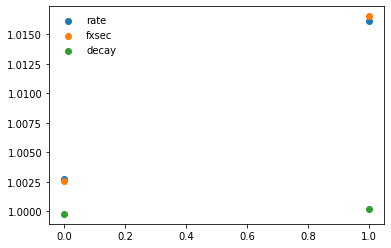

In [13]:
import matplotlib.pyplot as plt

ratios_rate = []
ratios_fxsec = []
ratios_decay = []
for pair in df:
    ratios_rate.append(np.sum(pair[0]['w_event_rate'])/np.sum(pair[1]['w_event_rate']))
    ratios_fxsec.append(np.sum(pair[0]['w_flux_avg_xsec'])/np.sum(pair[1]['w_flux_avg_xsec']))
    
    ratios_decay.append(np.sum(pair[0]['w_decay_rate_0'])/np.sum(pair[1]['w_decay_rate_0']))

plt.scatter(range(2),ratios_rate, label="rate")
plt.scatter(range(2),ratios_fxsec, label="fxsec")
plt.scatter(range(2),ratios_decay, label="decay")
plt.legend(frameon=False)

# plt.scatter(range(0,2),case1, c='blue')
# plt.scatter(range(0,2),case2, c='orange')

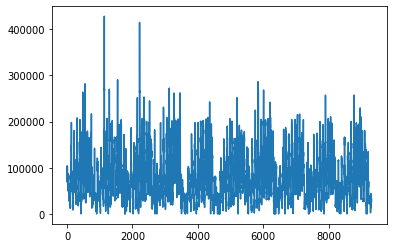

In [14]:
plt.plot(df_1['w_flux_avg_xsec'])
# plt.yscale("log")
# plt.ylim(1,1e7)


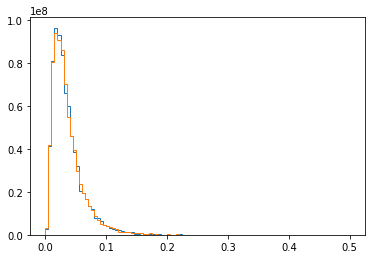

In [15]:
df1,df2 = df[0]
p1 = (df1['P_projectile'] - df1['P_decay_N_parent']).to_numpy()
h1 = dn.Cfourvec.dot4(p1,p1)

p2 = (df2['P_projectile'] - df2['P_decay_N_parent']).to_numpy()
h2 = dn.Cfourvec.dot4(p2,p2)

_ = plt.hist(np.sqrt(-h1), bins=100, range=(0,0.5), histtype='step', weights=df1['w_event_rate'], lw=1)
_ = plt.hist(np.sqrt(-h2), bins=100, range=(0,0.5), histtype='step', weights=df2['w_event_rate'], lw=1)


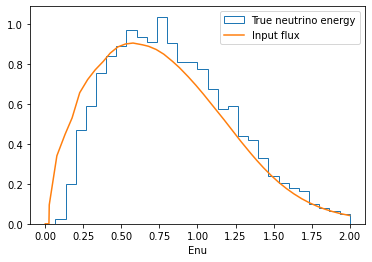

In [16]:
p1 = (df_2['P_projectile']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']+df_1['P_decay_N_daughter']).to_numpy()
h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,2), weights=df_2['w_flux_avg_xsec'],density=True, label='True neutrino energy')
plt.xlabel("Enu")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

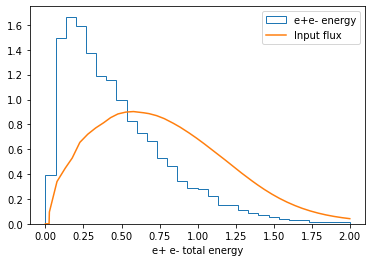

In [18]:

p1 = (df_2['P_decay_ell_minus']+df_2['P_decay_ell_plus']).to_numpy()

h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,2), weights=df_2['w_event_rate'],density=True, label='e+e- energy')
plt.xlabel("e+ e- total energy")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

Text(0.5, 0, 'Enu')

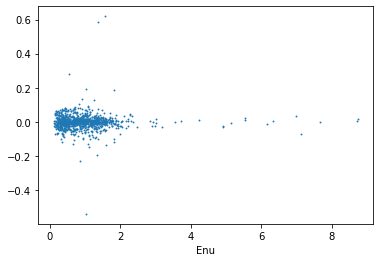

In [129]:
p1 = (df_1['P_projectile']).to_numpy()
x = p1[:,0]
y  = (df_1['P_decay_N_parent']).to_numpy()[:,2]
_ = plt.scatter(x, y, marker='.', s=3,  label='True neutrino energy')
plt.xlabel("Enu")
